In [31]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

%config InlineBackend.figure_format = 'svg'
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


In [32]:
df1 = pd.read_csv('data/turnstile_180623.txt')
df2 = pd.read_csv('data/turnstile_180602.txt')
df1.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,6658725,2257032
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068


In [33]:
# df_alldata = pd.concat([df1,df2])

Check hierarchy of members

In [34]:
# df1.groupby(['STATION', 'UNIT', 'C/A'])['SCP'].unique().head(5)

In [35]:
## strip whitespace in column headers
newcolumns = df1.columns.str.strip()
df1.columns = newcolumns

In [36]:
df1['DATETIME'] = df1['DATE'] + ' ' + df1['TIME']
df1['DATETIME'] = pd.to_datetime(df1['DATETIME'])
df1.sample(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
28767,G009,R151,02-05-00,CONEY IS-STILLW,DFNQ,BMT,06/20/2018,05:00:00,REGULAR,2060,0,2018-06-20 05:00:00
8260,A049,R088,02-00-02,CORTLANDT ST,RNW,BMT,06/20/2018,21:00:00,REGULAR,608619,333095,2018-06-20 21:00:00
124600,R113,R028,01-01-00,FULTON ST,2345ACJZ,IRT,06/18/2018,15:00:00,REGULAR,235043273,151129214,2018-06-18 15:00:00


In [37]:
df1['ENTRY_DIFFS'] = (df1
                      .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                      .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRIES']
                      .diff())
df1['EXIT_DIFFS'] = (df1
                     .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRIES', 'EXITS', 'DATETIME']]
                     .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXITS']
                     .diff())

In [38]:
## check to make sure NaN appears for the first row for an SCP
df1[40:].head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
40,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,16:00:00,REGULAR,6666235,2259814,2018-06-22 16:00:00,329.0,74.0
41,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/22/2018,20:00:00,REGULAR,6666924,2259874,2018-06-22 20:00:00,689.0,60.0
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,00:00:00,REGULAR,5964171,1334598,2018-06-16 00:00:00,NaN,NaN
43,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,5964188,1334606,2018-06-16 04:00:00,17.0,8.0
44,A002,R051,02-00-01,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,5964202,1334630,2018-06-16 08:00:00,14.0,24.0


In [39]:
## purge values that don't make any sense in ENTRY_DIFFS and EXIT_DIFFS
df1.loc[df1['ENTRY_DIFFS'] < 0, 'ENTRY_DIFFS'] = 0
df1.loc[df1['ENTRY_DIFFS'] > 100000, 'ENTRY_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] < 0, 'EXIT_DIFFS'] = 0
df1.loc[df1['EXIT_DIFFS'] > 100000, 'EXIT_DIFFS'] = 0

In [40]:
## make series of weekly total SCP-entry_diffs and SCP-exit_diffs pairs
SCP_ENTRY_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_EXIT_weektotals = (df1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'EXIT_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['EXIT_DIFFS']
                  .sum())
SCP_ENTRY_weektotals.head(5)

STATION  UNIT  C/A   SCP     
1 AV     R248  H007  00-00-00    24023.0
                     00-00-01    31421.0
                     00-03-00     6240.0
                     00-03-01     4825.0
                     00-03-02     8038.0
Name: ENTRY_DIFFS, dtype: float64

(array([1871., 1302.,  806.,  429.,  174.,   75.,   33.,   10.,    8.,
           2.]),
 array([    0. ,  4524.3,  9048.6, 13572.9, 18097.2, 22621.5, 27145.8,
        31670.1, 36194.4, 40718.7, 45243. ]),
 <a list of 10 Patch objects>)

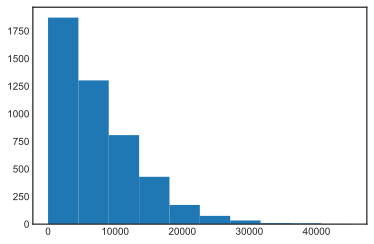

In [41]:
plt.hist(SCP_ENTRY_weektotals)

In [42]:
## display the highest-traffic stations for this week (all entries+ all exits)
STATION_traffic_weektotals = (SCP_ENTRY_weektotals + SCP_EXIT_weektotals).groupby(['STATION']).sum()
STATION_traffic_weektotals.sort_values(ascending=False).head(10)

STATION
34 ST-PENN STA     1868658.0
GRD CNTRL-42 ST    1711147.0
34 ST-HERALD SQ    1387533.0
14 ST-UNION SQ     1220524.0
TIMES SQ-42 ST     1218558.0
23 ST              1116914.0
FULTON ST          1078230.0
42 ST-PORT AUTH    1019479.0
86 ST               876680.0
125 ST              873321.0
dtype: float64

In [43]:
# df1['DATETIME'].min() + timedelta(days=1)
# df1['DATETIME'].max()

In [44]:
## make an array of midnight datetimes for slicing dataframe by days
day_markers = np.arange(df1['DATETIME'].min(), df1['DATETIME'].max(), timedelta(days=1))
day_markers = np.append(day_markers, df1['DATETIME'].max())
day_markers

array([datetime.datetime(2018, 6, 16, 0, 0),
       datetime.datetime(2018, 6, 17, 0, 0),
       datetime.datetime(2018, 6, 18, 0, 0),
       datetime.datetime(2018, 6, 19, 0, 0),
       datetime.datetime(2018, 6, 20, 0, 0),
       datetime.datetime(2018, 6, 21, 0, 0),
       datetime.datetime(2018, 6, 22, 0, 0),
       Timestamp('2018-06-22 23:58:32')], dtype=object)

In [45]:
first_datetime = df1['DATETIME'].min()
df_day1 = df1[(df1['DATETIME'] > first_datetime)&(df1['DATETIME'] <= first_datetime + timedelta(days=1))]
df_day1.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,04:00:00,REGULAR,6658747,2257036,2018-06-16 04:00:00,22.0,4.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,08:00:00,REGULAR,6658766,2257068,2018-06-16 08:00:00,19.0,32.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,12:00:00,REGULAR,6658866,2257139,2018-06-16 12:00:00,100.0,71.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,16:00:00,REGULAR,6659043,2257188,2018-06-16 16:00:00,177.0,49.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/16/2018,20:00:00,REGULAR,6659281,2257223,2018-06-16 20:00:00,238.0,35.0


In [46]:
SCP_ENTRY_day1totals = (df_day1
                  .sort_values(by=['STATION','UNIT', 'C/A', 'SCP'])[['STATION','UNIT', 'C/A', 'SCP', 'ENTRY_DIFFS']]
                  .groupby(['STATION', 'UNIT', 'C/A', 'SCP'])['ENTRY_DIFFS']
                  .sum())
SCP_ENTRY_day1totals.sort_values(ascending=False).head(5)

STATION          UNIT  C/A   SCP     
QUEENSBORO PLZ   R121  R509  00-00-00    7008.0
BEDFORD AV       R235  H009  00-03-04    6830.0
QUEENSBORO PLZ   R121  R509  00-00-01    5634.0
BEDFORD AV       R235  H009  00-03-03    4665.0
34 ST-HERALD SQ  R022  N506  00-05-05    4608.0
Name: ENTRY_DIFFS, dtype: float64

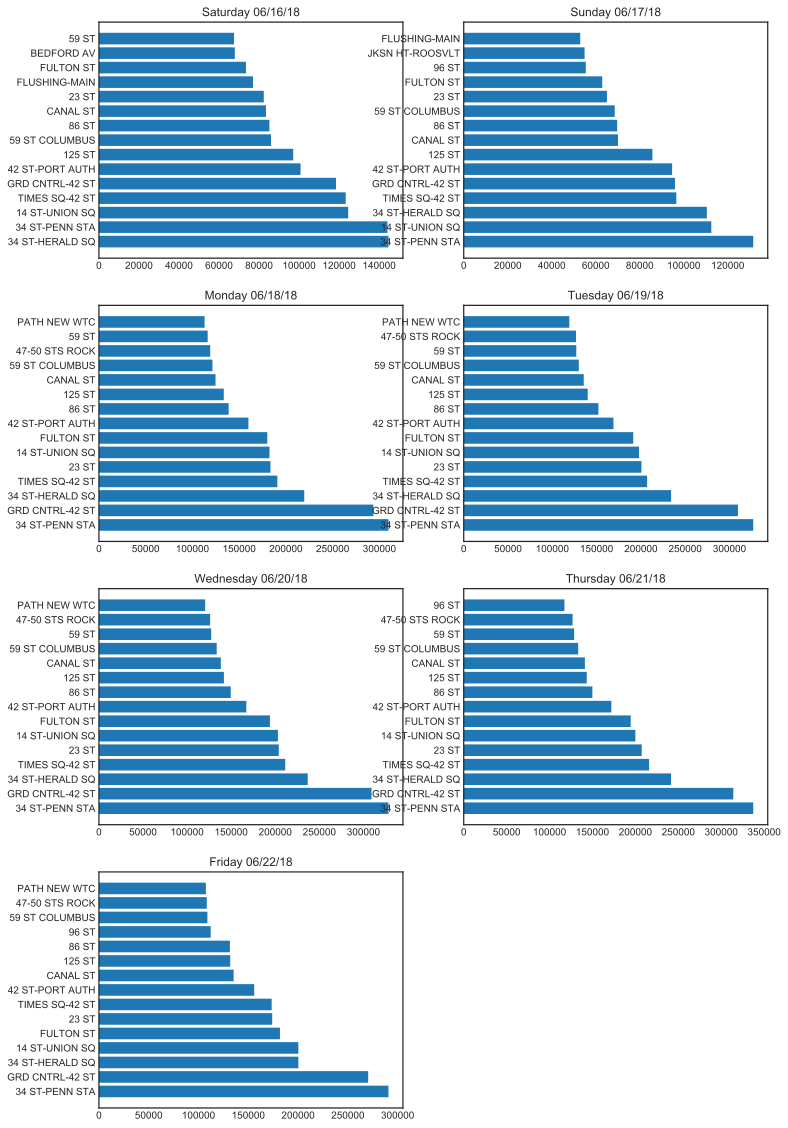

In [47]:
## This code generates bar charts for each day's top 10 highest-traffic stations

plt.figure(figsize=[12,20])
for index, day in enumerate(day_markers[:-1]):
    ## Number of stations to be returned. (Top 10? Top 15?)
    snum = 15
    
    ## Slice dataframe to a single day's values
    df_day = df1[(df1['DATETIME'] > day)&(df1['DATETIME'] <= day_markers[index+1])]
    
    ## Sum every station's entries and exits for the day
    STATION_ENTRY_daytotals = (df_day
                  .sort_values(by=['STATION'])[['STATION', 'ENTRY_DIFFS']]
                  .groupby(['STATION'])['ENTRY_DIFFS']
                  .sum())
    STATION_EXIT_daytotals = (df_day
                  .sort_values(by=['STATION'])[['STATION', 'EXIT_DIFFS']]
                  .groupby(['STATION'])['EXIT_DIFFS']
                  .sum())
    
    ## Aggregate entry and exit data into one column (total traffic)
    STATION_BOTH_daytotals = (STATION_ENTRY_daytotals + STATION_EXIT_daytotals).groupby(['STATION']).sum()
    
    STATION_BOTH_daytotals.sort_values(ascending=False, inplace=True)
    
    ## Make a list of station names for labeling bar chart
    ticks_y = STATION_BOTH_daytotals[:snum].index.tolist()
    
    plt.subplot(4, 2, index+1)
    plt.barh(np.arange(snum),STATION_BOTH_daytotals.values[:snum])
    plt.yticks(np.arange(snum), ticks_y)
    plt.title(day.strftime("%A %m/%d/%y"))

In [48]:
df1.to_csv('mta.csv', sep='\t')

In [49]:
location=pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [50]:
location.columns

Index(['Station ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude'],
      dtype='object')

In [51]:
location.columns=['Station_ID', 'Complex ID', 'GTFS Stop ID', 'Division', 'Line',
       'Stop Name', 'Borough', 'Daytime Routes', 'Structure', 'GTFS Latitude',
       'GTFS Longitude']

In [52]:
tind=df1[df1.STATION=='TIMES SQ-42 ST'].index
df1.loc[tind,'Station_ID']=11

tind=df1[df1.STATION=='GRD CNTRL-42 ST'].index
df1.loc[tind,'Station_ID']=402

tind=df1[df1.STATION=='34 ST-HERALD SQ'].index
df1.loc[tind,'Station_ID']=12

tind=df1[df1.STATION=='34 ST-PENN STA'].index
df1.loc[tind,'Station_ID']=164

tind=df1[df1.STATION=='23 ST'].index
df1.loc[tind,'Station_ID']=165

tind=df1[df1.STATION=='FULTON ST'].index
df1.loc[tind,'Station_ID']=106

tind=df1[df1.STATION=='42 ST-PORT AUTH'].index
df1.loc[tind,'Station_ID']=163

tind=df1[df1.STATION=='125 ST'].index
df1.loc[tind,'Station_ID']=153

tind=df1[df1.STATION=='86 ST'].index
df1.loc[tind,'Station_ID']=158

tind=df1[df1.STATION=='14 ST-UNION SQ'].index
df1.loc[tind,'Station_ID']=15

In [53]:
df=pd.merge(df1,location,on='Station_ID')

In [55]:
df1[df1.STATION=='42 ST-PORT AUTH']

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,Station_ID
47821,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,02:00:00,REGULAR,10426616,15911614,2018-06-16 02:00:00,NaN,NaN,163.0
47822,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,06:00:00,REGULAR,10426659,15911685,2018-06-16 06:00:00,43.0,71.0,163.0
47823,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,10:00:00,REGULAR,10426727,15912043,2018-06-16 10:00:00,68.0,358.0,163.0
47824,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,14:00:00,REGULAR,10426908,15912783,2018-06-16 14:00:00,181.0,740.0,163.0
47825,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,18:00:00,REGULAR,10427288,15913588,2018-06-16 18:00:00,380.0,805.0,163.0
47826,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/16/2018,22:00:00,REGULAR,10427555,15914240,2018-06-16 22:00:00,267.0,652.0,163.0
47827,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/17/2018,02:00:00,REGULAR,10428075,15914500,2018-06-17 02:00:00,520.0,260.0,163.0
47828,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/17/2018,06:00:00,REGULAR,10428124,15914565,2018-06-17 06:00:00,49.0,65.0,163.0
47829,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/17/2018,10:00:00,REGULAR,10428176,15914877,2018-06-17 10:00:00,52.0,312.0,163.0
47830,N060,R010,01-00-00,42 ST-PORT AUTH,ACENGRS1237W,IND,06/17/2018,14:00:00,REGULAR,10428210,15915550,2018-06-17 14:00:00,34.0,673.0,163.0


In [56]:
df.to_csv('top_ten.csv', sep='\t')

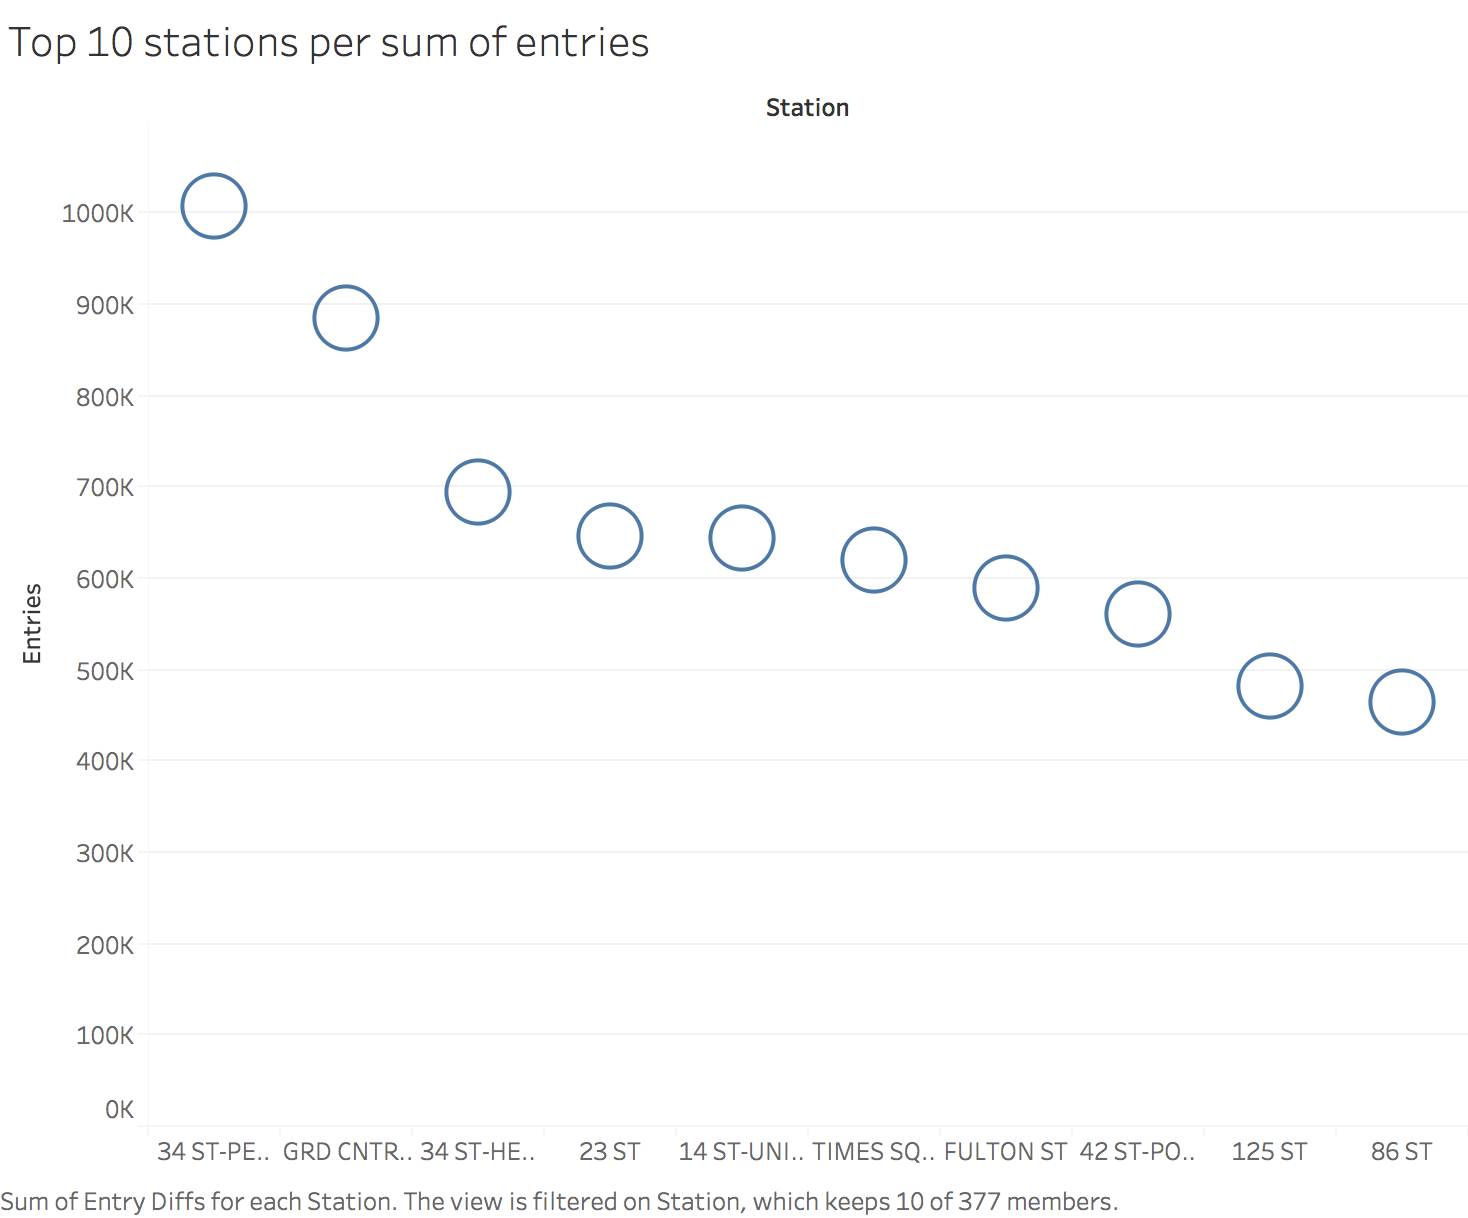


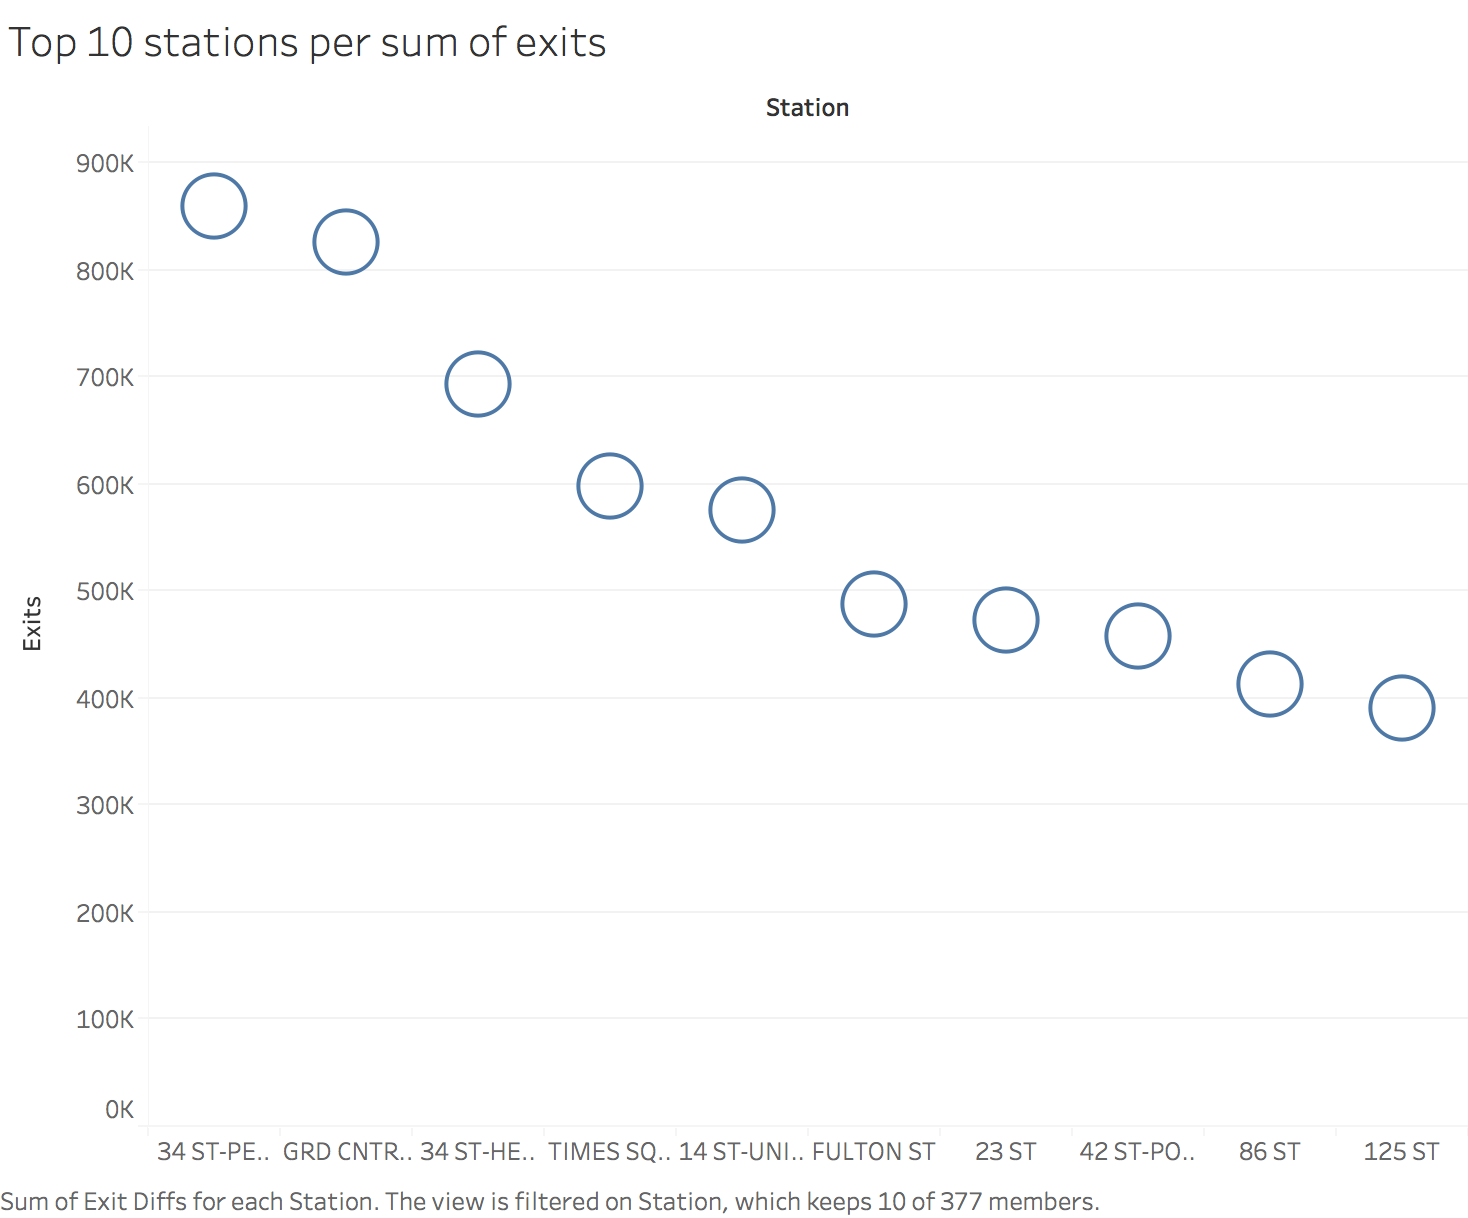


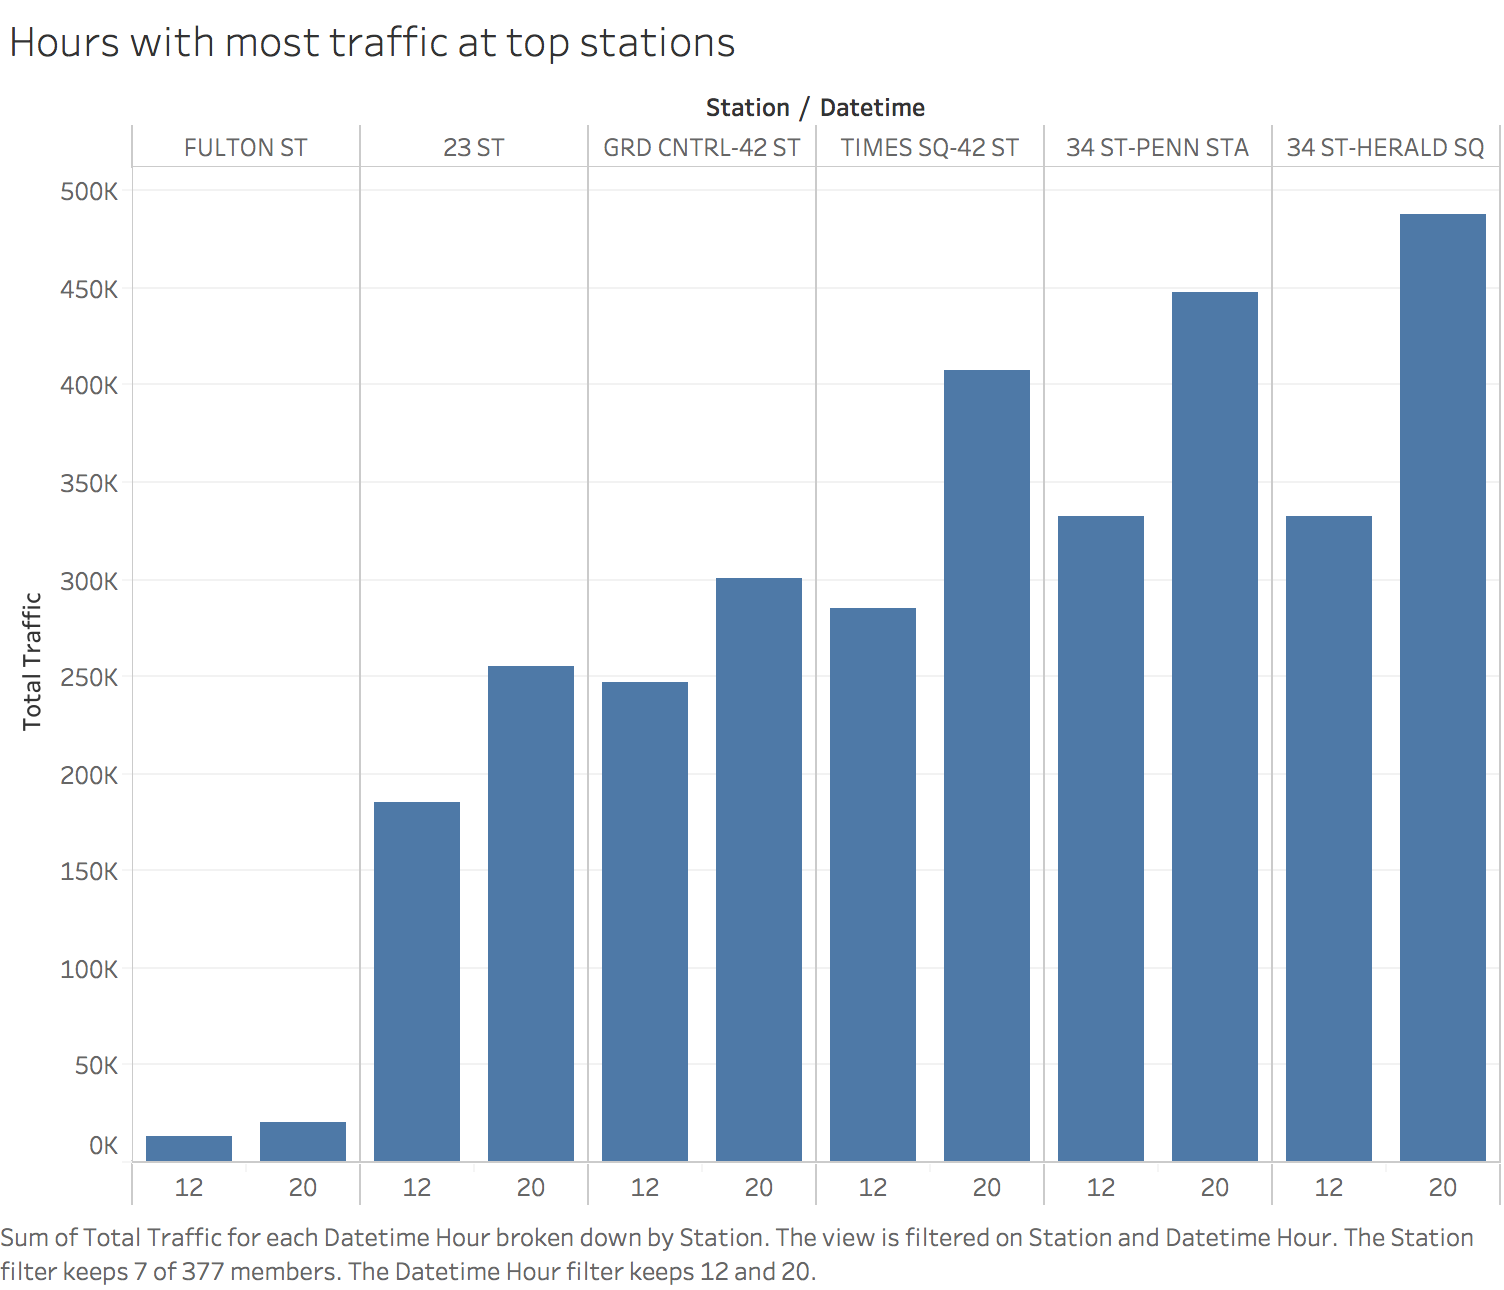

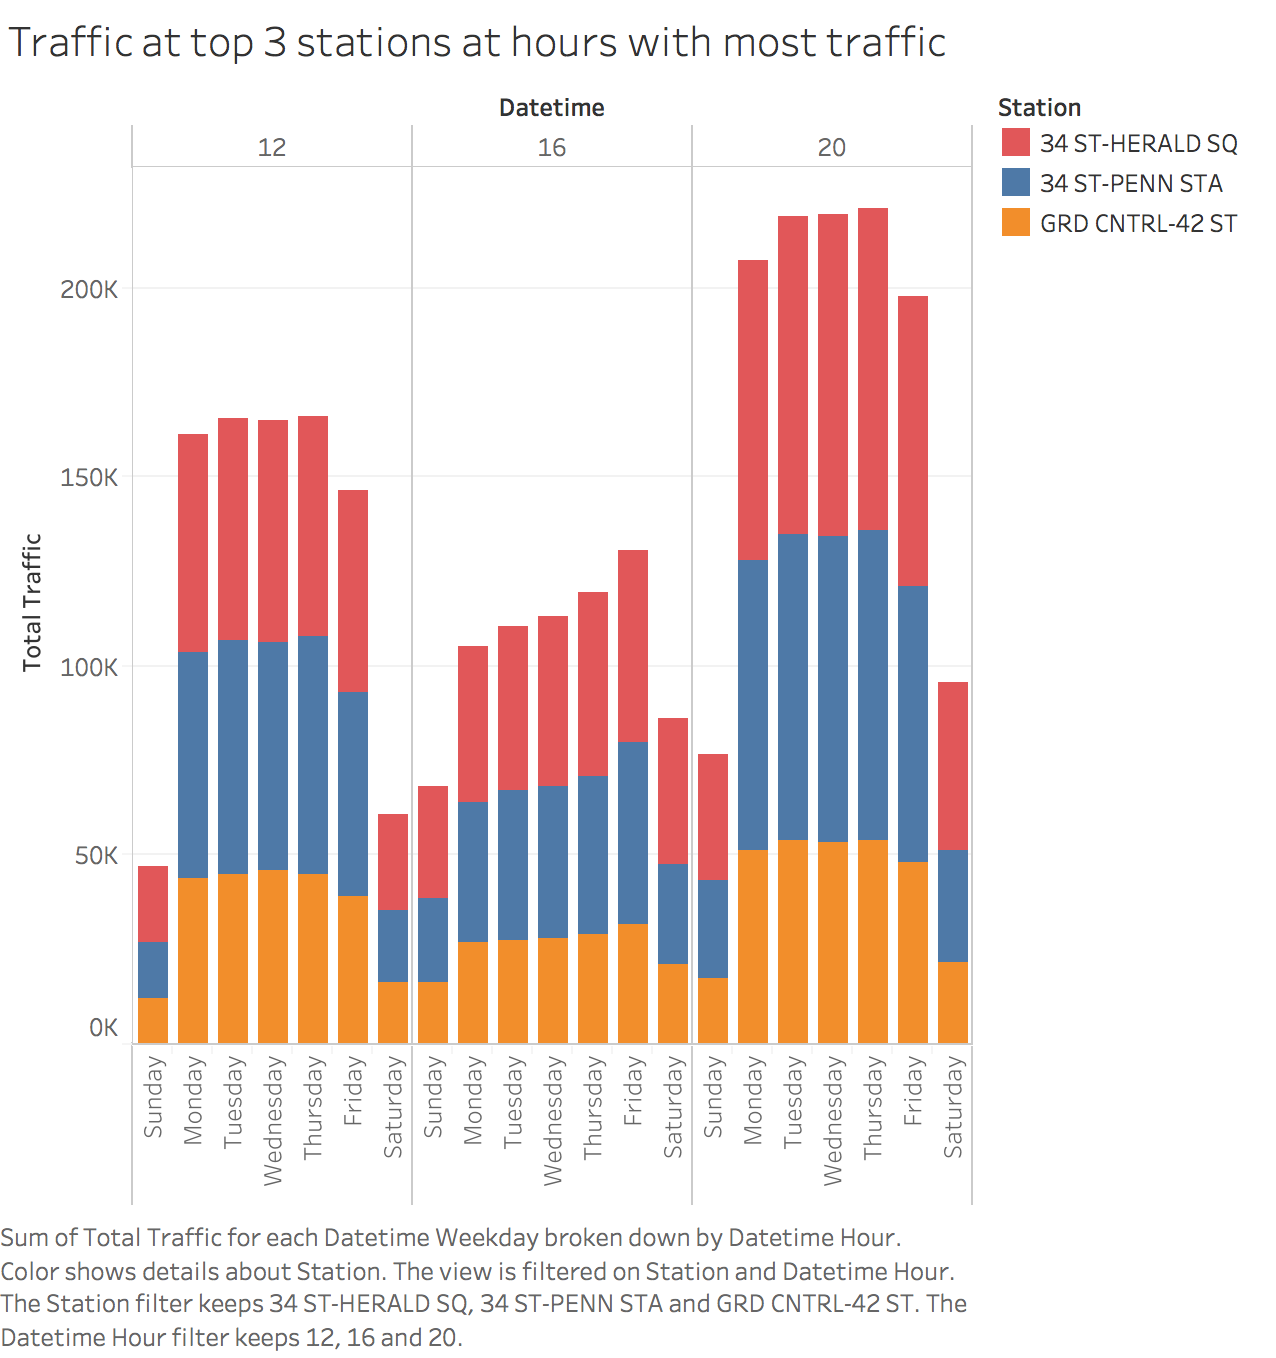

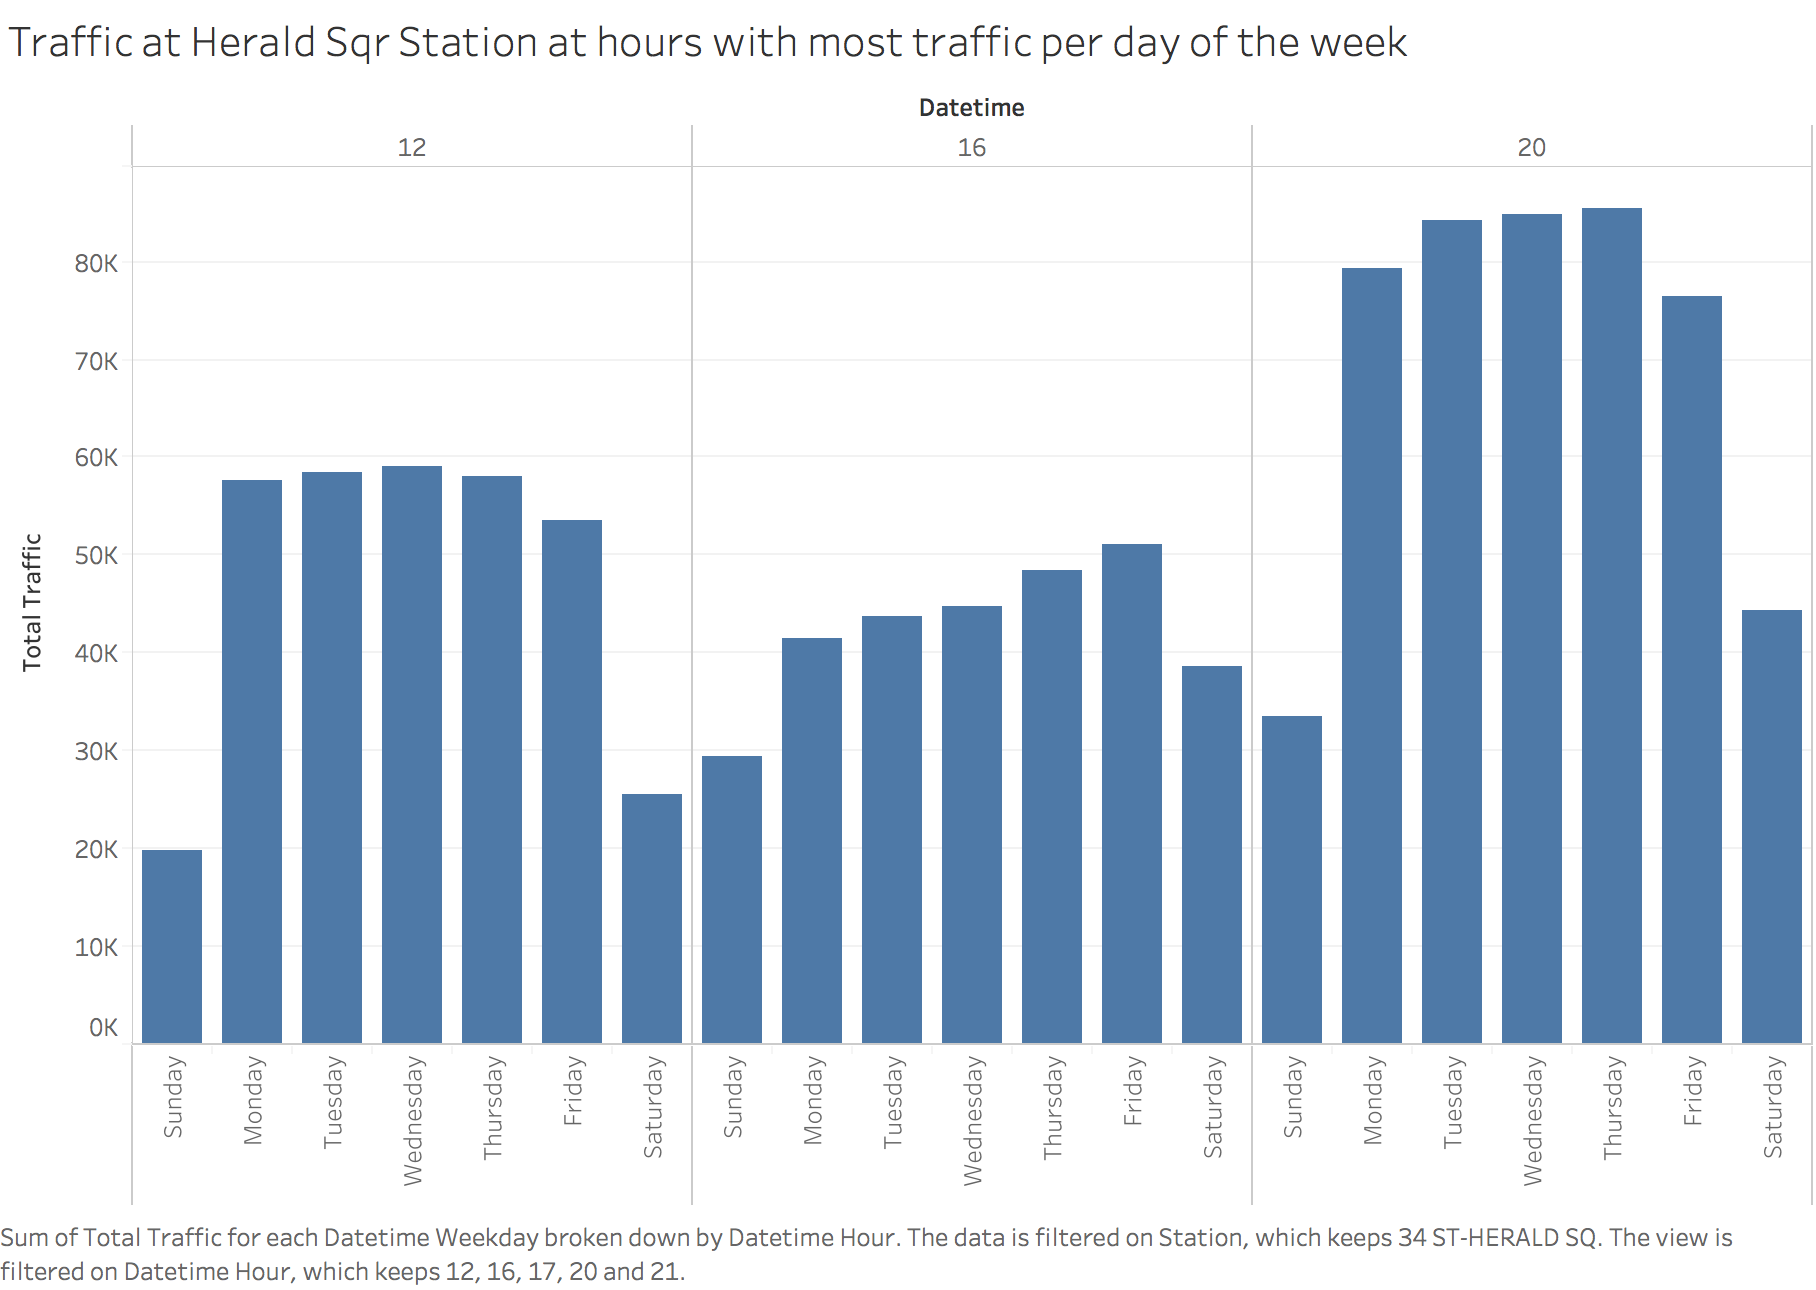

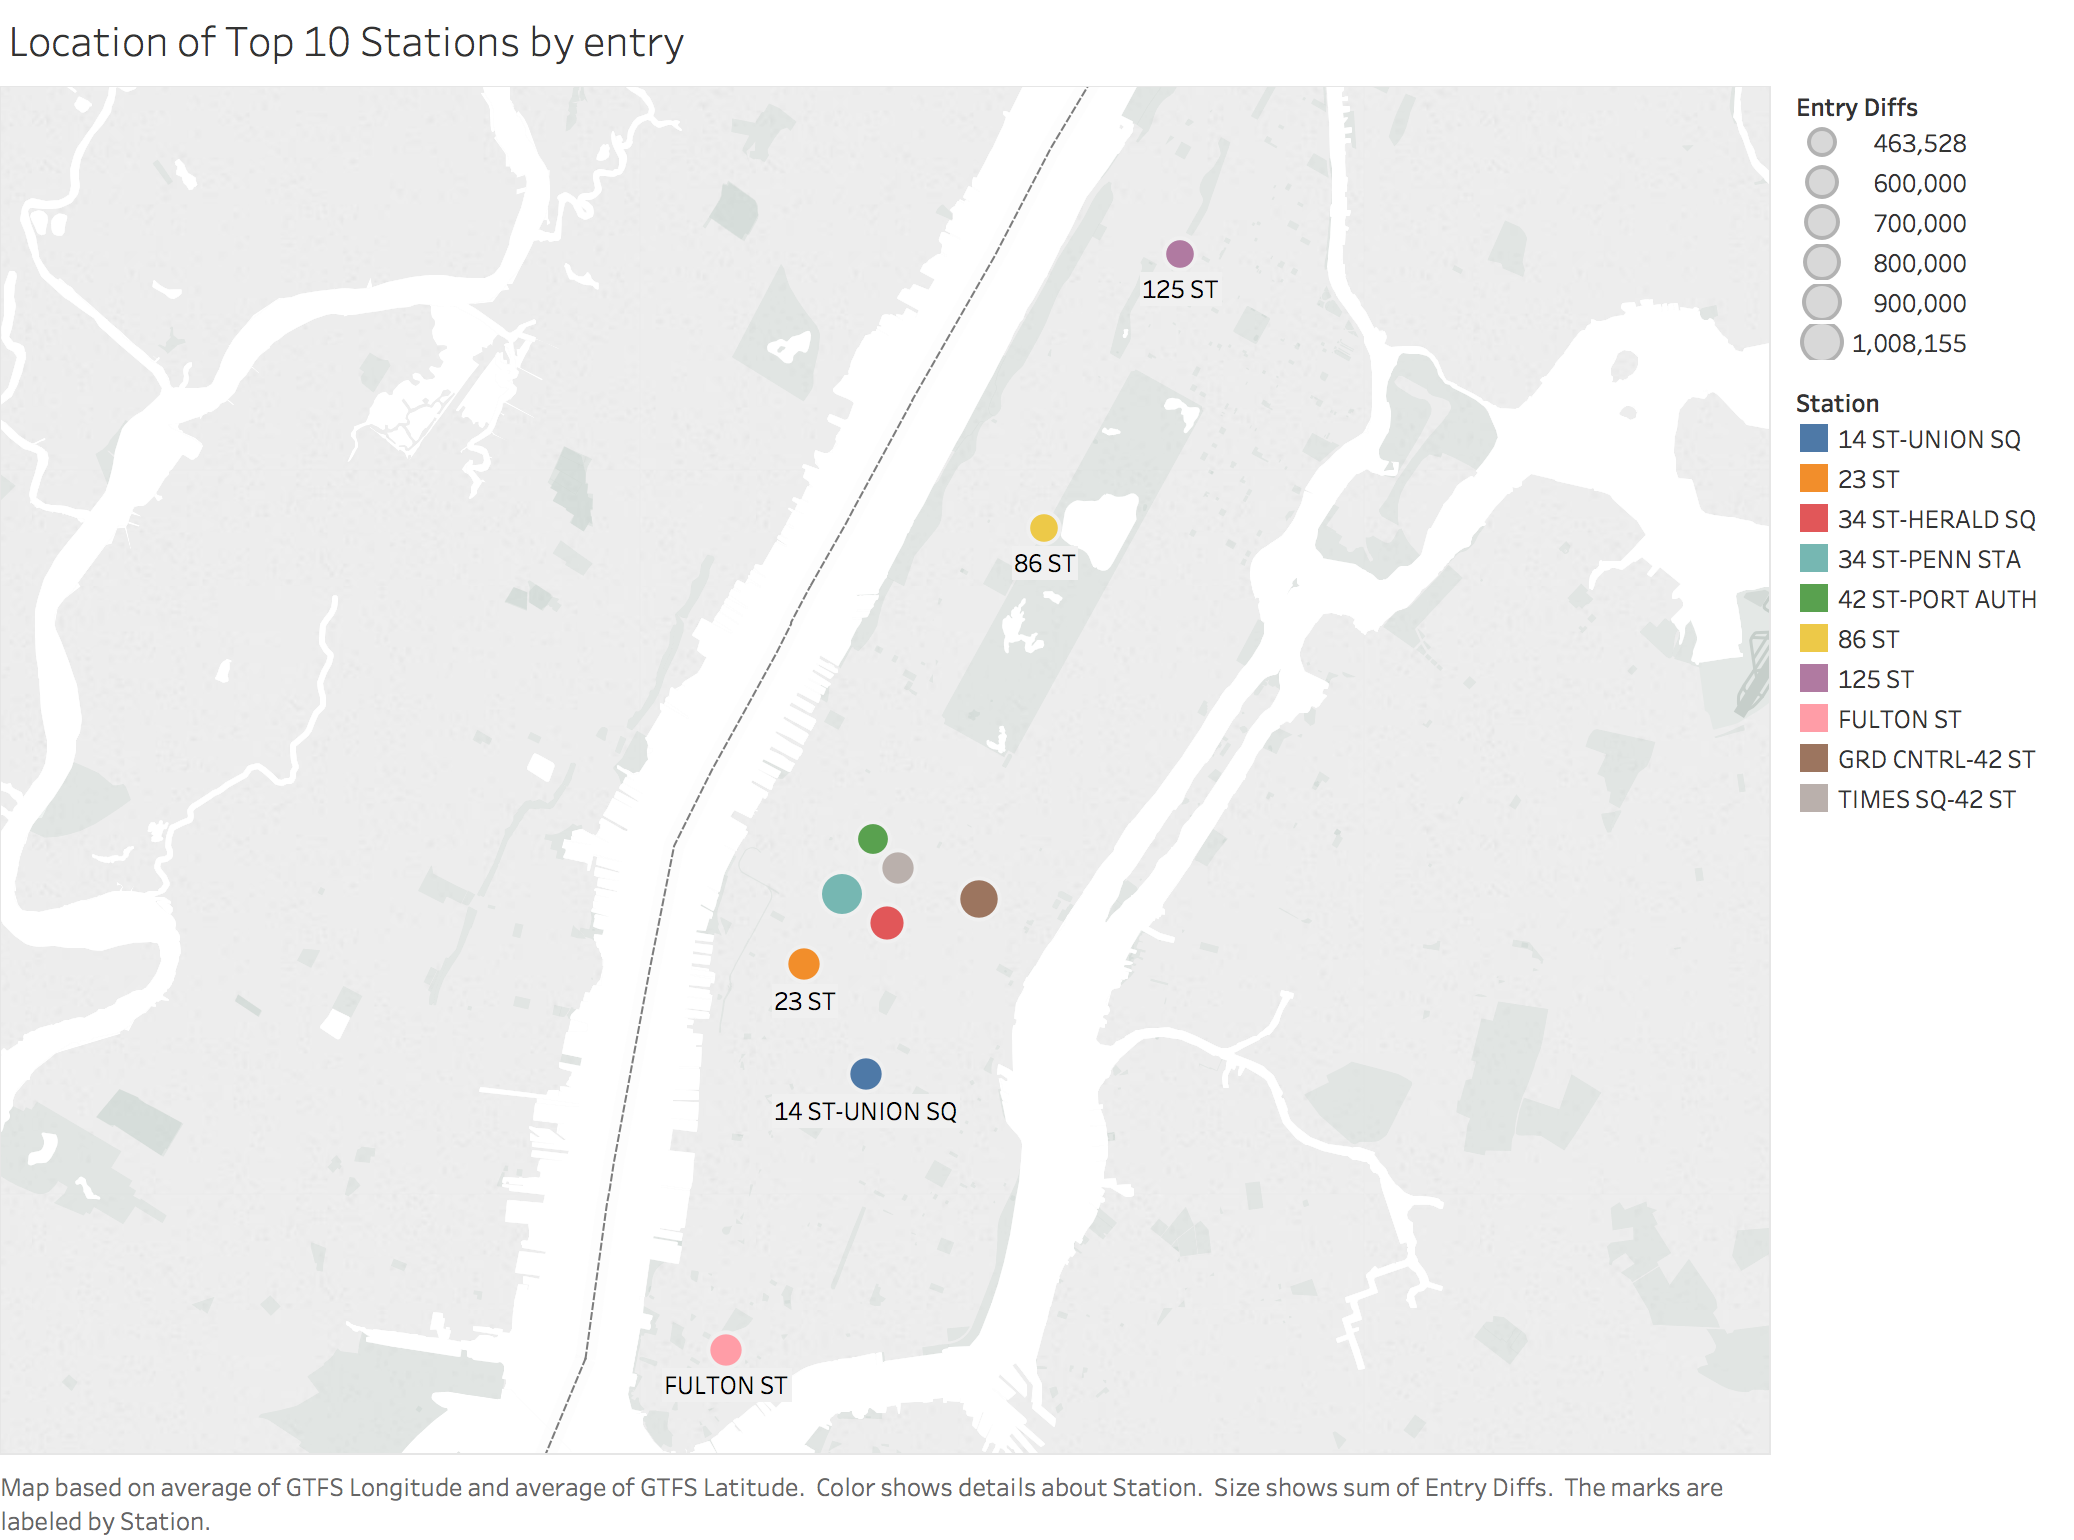